# Transaction Level Models

While it was expected that aggregation of features in a somewhat arbitrary manner would result in the loss of information, it was not expected that such an approach would not be able to beat the baseline score of guessing only zeros.  Here, we explore first training models to try and predict total revenue for each user session, this time using the catboost library.  This decision tree ensemble model includes a categorical encoding algorithm that promises to deal with labelling unseen categories in an efficient manner that improves accuracy.  We leave all features in for this notebook, as well as add in time-lagged features in hopes that these might also help predict transaction revenue, the intuition being that past behavior should tell us something about whether a user will finally make a purchase.

While we ultimately end up with higher accuracy, we find the same qualitative behavior as before.  The results of this model do not lend themselves to inference, but could have some value in looking at customer value anyway.

In [1]:
import pandas as pd
import sqlalchemy
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import catboost as cb

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using 

In [2]:
with open('credentials.txt') as f:
    path = f.read()
    
engine = sqlalchemy.create_engine(path)

In [3]:
with open('../pickles/field_dict.pkl', 'rb') as f:
    field_dict = pickle.load(f)
    
with open('../pickles/useless_fields.pkl', 'rb') as f:
    useless_fields = pickle.load(f)

with open('../pickles/adwordsClickInfo_keys.pkl', 'rb') as f:
    adwordsClickInfo_keys = pickle.load(f)
    
with open('../pickles/channel_groups.pkl', 'rb') as f:
    channel_groups = pickle.load(f)
    
with open('../pickles/field_vals.pkl', 'rb') as f:
    field_vals = pickle.load(f)

In [ ]:
query = """
SELECT fullVisitorId
FROM train_data
GROUP BY fullVisitorId
HAVING SUM(CAST(totals ->> 'transactionRevenue' AS numeric)) > 0
"""

customers = pd.read_sql_query(query, engine)

In [ ]:
with open('../pickles/train_customer_ids.pkl', 'wb') as f:
    pickle.dump(customers, f)

In [ ]:
query = """
SELECT fullVisitorId
FROM train_data
GROUP BY fullVisitorId
HAVING SUM(CAST(totals ->> 'transactionRevenue' AS numeric)) IS NULL
"""

lookers = pd.read_sql_query(query, engine)

In [ ]:
with open('./pickles/train_looker_ids.pkl', 'wb') as f:
    pickle.dump(lookers, f)

In [4]:
with open('../pickles/train_customer_ids.pkl', 'rb') as f:
    train_customer_ids = pickle.load(f)

There is the question of scaling the revenue.  We scale it to dollars just to get a natural sense of scale during the training, but this is an arbitrary decision.  The other queries just deal with the json format.

In [5]:
def revTemplate(key, name, num_type = 'FLOAT'):
    return f"""COALESCE(CAST({key} ->> '{name}' AS {num_type}), 0)/10^6 AS {name}"""

def jnumTemplate(key, name, num_type = 'INT'):
    return f"""COALESCE(CAST({key} ->> '{name}' AS {num_type}), 0) AS {name}"""

def numTemplate(name):
    return f"""COALESCE({name}, 0) AS {name}"""

def jstrTemplate(key, name):
    return f"{key} ->> '{name}' AS {name}"

def strTemplate(name):
    return f"{name}"

def adwordsTemplate(name):
    return f"CAST(trafficSource ->> 'adwordsClickInfo' AS JSONB) ->> '{name}' AS {name}"

In [6]:
def getQuery(dataset = 'train'):
    numeric_cols = ['visitNumber', 'newVisits', 'bounces', 'pageviews', 'visits', 'hits', 'transactionRevenue']
    if dataset != 'train':
        numeric_cols.pop()
    selects = []
    for cat, subcats in field_dict.items():
        for subcat in subcats:
            if subcat not in useless_fields[dataset]:
                if subcat == 'transactionRevenue':
                    selects.append(revTemplate(cat, subcat, 'NUMERIC'))
                elif subcat in numeric_cols:
                    selects.append(jnumTemplate(cat, subcat))
                elif subcat == 'adwordsClickInfo':
                    for key in adwordsClickInfo_keys:
                        selects.append(adwordsTemplate(key))
                else:
                    selects.append(jstrTemplate(cat, subcat))
    selects.extend([numTemplate('visitNumber'), 
                    strTemplate('channelGrouping'),
                    strTemplate('fullVisitorId'),
                    numTemplate('visitStartTime'),
                   ])
    return ', '.join(selects)

In [7]:
qstring = getQuery()

In [8]:
with open('../pickles/top_order.pkl', 'rb') as f:
    top_order = pickle.load(f)

In [9]:
#Note to self: if you don't change the ids list, you will lose a lot of ids.
#this is regarding selectively training on data that does not involve bounces.
#you will train on less data than you think, but you won't inflate the score at least by having those you excluded.
def getUserData(user_list):
    users = "\', \'".join(user_list)
    query = f"""
    SELECT {qstring}
    FROM train_data
    WHERE fullVisitorId IN (\'{users}\')
    """

    return pd.read_sql_query(query, engine, parse_dates=['visitstarttime'])

In [10]:
with open('../pickles/objects.pkl', 'rb') as f:
    objects = pickle.load(f)

In [11]:
def adjustCols(df, drop_ids = True, ignore_bounce = True):
    back_looking = ['bounces', 'hits', 'newvisits', 'pageviews']
    
    df = df.sort_values(['fullvisitorid','visitstarttime'])
    #turns out the for loop checks col_order dynamically, temporary list needed to avoid infinite loop
    for col in back_looking:
        df[f'{col}last'] = df.groupby('fullvisitorid')[col].shift(1)
        df[f'{col}two'] = df.groupby('fullvisitorid')[col].shift(2)
    df['sincelast'] = df.groupby('fullvisitorid').visitstarttime.diff().map(lambda x: x.days + x.seconds/86400)
    df['sincetwo'] = df.groupby('fullvisitorid').visitstarttime.diff(2).map(lambda x: x.days + x.seconds/86400)
    df['hour'] = df.visitstarttime.map(lambda x: x.hour)
    df['weekday'] = df.visitstarttime.map(lambda x: x.dayofweek)
    df['month'] = df.visitstarttime.map(lambda x: x.month)
    
    if drop_ids:
        df = df.drop('fullvisitorid', axis=1)
        
    if ignore_bounce:
        df = df.query('bounces==0')
 
    return df.drop('visitstarttime', axis=1)

In [12]:
with open('../pickles/train_customer_ids.pkl', 'rb') as f:
    train_customer_ids = pickle.load(f)

In [13]:
with open('../pickles/train_looker_ids.pkl', 'rb') as f:
    train_looker_ids = pickle.load(f)

In [14]:
#shuffle now so we can just iterate through lists
from random import shuffle

def stratifiedIdSplit(test_size=0.5):
    customer_size = int(len(train_customer_ids)*test_size)
    looker_size = int(len(train_looker_ids)*test_size)
    
    test_customers = list(np.random.choice(train_customer_ids.T.values[0], replace=False, size=customer_size))
    test_lookers = list(np.random.choice(train_looker_ids.T.values[0], replace=False, size=looker_size))
    
    train_customers = list(set(train_customer_ids.T.values[0]).difference(set(test_customers)))
    train_lookers = list(set(train_looker_ids.T.values[0]).difference(set(test_lookers)))
    
    test_customers.extend(test_lookers)
    train_customers.extend(train_lookers)
    
    shuffle(test_customers)
    shuffle(train_customers)
    
    return train_customers, test_customers

In [15]:
train_ids, test_ids = stratifiedIdSplit(0.3)

While we can hope a machine can learn what is unique about this outlier, the fact is that there is no one else like this user.  In our ensemble later, considering it is a system of gradient boosted trees, there is a very good chance that one of the forests will be awful at guessing because it was fit to minimize the error it would get from this outlier point.  With all its activity, though, perhaps the behavior could still fall in line with the other points of data.  For the fear of overfitting to this point, and because our validation can tell us nothing about how well it does on similar outliers (because there are none like it), we remove it from our model for now.

In [16]:
try:
    train_ids.remove(top_order.iloc[0,0])
except:
    test_ids.remove(top_order.iloc[0,0])

In [17]:
getUserData([test_ids[0]]).columns

Index(['devicecategory', 'ismobile', 'browser', 'operatingsystem', 'city',
       'continent', 'country', 'metro', 'networkdomain', 'region',
       'subcontinent', 'bounces', 'hits', 'newvisits', 'pageviews',
       'transactionrevenue', 'adcontent', 'adnetworktype',
       'criteriaparameters', 'gclid', 'isvideoad', 'page', 'slot',
       'targetingcriteria', 'campaign', 'campaigncode', 'istruedirect',
       'keyword', 'medium', 'referralpath', 'source', 'visitnumber',
       'channelgrouping', 'fullvisitorid', 'visitstarttime'],
      dtype='object')

In [18]:
def createChunk(ids_list, size, drop_ids = True, ignore_bounce=True):
    new_size = len(ids_list)
    if  new_size > size:
        new_size = size
    someppl = ids_list
    shuffle(someppl)
    someppl = someppl[:new_size]
    chunk = getUserData(someppl)
    chunk = adjustCols(chunk, drop_ids, ignore_bounce)
    
    return chunk.fillna(0), ids_list[new_size:]

In [19]:
trial_df = adjustCols(getUserData([top_order.iloc[0][0]])).drop('transactionrevenue', axis=1)

In [20]:
trial_vals = adjustCols(getUserData([top_order.iloc[0][0]])).transactionrevenue

In [21]:
cat_feets = np.where(trial_df.dtypes == object)[0]

In [22]:
trial_df.columns[cat_feets]

Index(['devicecategory', 'ismobile', 'browser', 'operatingsystem', 'city',
       'continent', 'country', 'metro', 'networkdomain', 'region',
       'subcontinent', 'adcontent', 'adnetworktype', 'criteriaparameters',
       'gclid', 'isvideoad', 'page', 'slot', 'targetingcriteria', 'campaign',
       'campaigncode', 'istruedirect', 'keyword', 'medium', 'referralpath',
       'source', 'channelgrouping'],
      dtype='object')

Instead of training a set of trees and losing most of the trees, let's make an ensemble.  We can blend it and fit to the actual target with a single ensemble in two stages; we fit by session while still preventing user leakage before using these to predict the sum of all sessions and fitting on a separate validation set.

If the number of folds is too large or small, we find that the system begins to more easily overfit and converges at a much lower score.  At the time of writing this, care was not taken in splitting the ids further, and many of these trees may be missing users who actually make purchases.  Too few trees and there is little information to be gained.  Somehow, the score is worse in this situation.  The code to execute the experiment is listed below.  Note we allow this stage to overfit to its training data.

In [42]:
id_holder = train_ids
fold = 15
holdouts = 3
fold_size = len(id_holder)//fold

models = []
first_ids = id_holder[:fold_size].copy()


def trainCB(train_set, eval_pool, model_list):
    model_list.append(cb.CatBoostRegressor(iterations = 1000,
                                           learning_rate  = .1,
                                           l2_leaf_reg = 100,
                                           cat_features = cat_feets,
                                           verbose = True))
    model_list[-1].fit(X = train_set.drop('transactionrevenue', axis=1),
                       y = train_set.transactionrevenue,
                       #use_best_model = True, 
                       #eval_set = eval_pool, 
                       #early_stopping_rounds = 10, 
                       metric_period = 250)

eval_chunk, id_holder = createChunk(id_holder, fold_size)
eval_chunk = cb.Pool(eval_chunk.drop('transactionrevenue', axis=1), 
                 eval_chunk.transactionrevenue, 
                 cat_features=cat_feets)
chunk, id_holder = createChunk(id_holder, fold_size)
trainCB(chunk, eval_chunk, models)


for n in range(fold - holdouts - 2):
    eval_chunk = chunk
    eval_chunk = cb.Pool(eval_chunk.drop('transactionrevenue', axis=1), 
                     eval_chunk.transactionrevenue, 
                     cat_features=cat_feets)
    if n < (fold - holdouts - 3):
        chunk, id_holder = createChunk(id_holder, fold_size)
    else:
        chunk = createChunk(first_ids, fold_size)[0]
    trainCB(chunk, eval_chunk, models)


0:	learn: 36.8417253	total: 137ms	remaining: 2m 16s
250:	learn: 32.0623022	total: 33s	remaining: 1m 38s
500:	learn: 30.3389416	total: 1m 6s	remaining: 1m 6s
750:	learn: 29.2576903	total: 1m 39s	remaining: 33.1s
999:	learn: 28.4875161	total: 2m 13s	remaining: 0us
0:	learn: 32.4021570	total: 135ms	remaining: 2m 14s
250:	learn: 27.5181605	total: 32.3s	remaining: 1m 36s
500:	learn: 25.4465195	total: 1m 4s	remaining: 1m 4s
750:	learn: 23.8570970	total: 1m 37s	remaining: 32.2s
999:	learn: 22.7985629	total: 2m 9s	remaining: 0us
0:	learn: 104.3853046	total: 128ms	remaining: 2m 7s
250:	learn: 89.0422130	total: 31.3s	remaining: 1m 33s
500:	learn: 80.7562266	total: 1m 3s	remaining: 1m 3s
750:	learn: 75.8430757	total: 1m 35s	remaining: 31.7s
999:	learn: 72.2953291	total: 2m 8s	remaining: 0us
0:	learn: 66.9413343	total: 131ms	remaining: 2m 11s
250:	learn: 57.8270408	total: 32.4s	remaining: 1m 36s
500:	learn: 52.8344651	total: 1m 5s	remaining: 1m 5s
750:	learn: 48.9728531	total: 1m 39s	remaining: 32

At the arbitrary fold size of 8, we still get over sixty-two thousand users, and expect a good number of users to be paying customers.  We reserve 3 of these folds for validation and predicting the log of the sums.  We will also use the previous fold for validation, mostly to save space and time to be honest, though the first and last rounds must be treated separately.

In [43]:
del chunk, eval_chunk

In [ ]:
with open('../models/cb_overfit_stage1.pkl', 'wb') as f:
    pickle.dump(models, f)

In [ ]:
with open('../models/cb_overfit_stage1.pkl', 'rb') as f:
    models = pickle.load(f)

We train the second stage here, testing against the sum of all transaction revenue per user.

In [44]:
val_df = createChunk(id_holder, len(id_holder), drop_ids=False, ignore_bounce=False)[0]

In [45]:
val_x = val_df.drop('transactionrevenue', axis=1)
val_y = val_df[['fullvisitorid', 'transactionrevenue']]

In [46]:
predicts = [model.predict(val_x) for model in models]

In [47]:
for i in range(len(models)):
    val_x[f'predicted_{i}'] = (1 - val_x.bounces)*predicts[i] 

In [48]:
kept_columns = ['fullvisitorid', 'pageviews', 'newvisits', 'visitnumber', 'bounces', 'sincelast', 'sincetwo', 'pageviewslast', 'pageviewstwo']
col_mask = [column in kept_columns or 'predicted_' in column for column in val_x.columns.values]
x = val_x.loc[:,col_mask].groupby('fullvisitorid').sum()
x2 = val_x.loc[:,col_mask].groupby('fullvisitorid').std()
x = x.join(x2, lsuffix='_mean', rsuffix='_std')

In [49]:
y = val_y.groupby('fullvisitorid').sum().applymap(lambda x: np.log(10**6*x + 1)).loc[x.index, :]

In [50]:
split = int(len(x)*.3)

In [51]:
eval_set = cb.Pool(data = x.iloc[:split, :], label = y.iloc[:split, :])
train_set = cb.Pool(data = x.iloc[split:, :], label = y.iloc[split:, :])

In [66]:
censemble = cb.CatBoostRegressor(iterations = 3000,
                                 learning_rate  = .03,
                                 l2_leaf_reg = 100,
                                 use_best_model = True,
                                 bagging_temperature = 1,
                                 depth = 9,
                                 verbose = True)

In [67]:
censemble.fit(train_set, eval_set=eval_set, use_best_model=True, early_stopping_rounds = 10, metric_period = 20)

0:	learn: 2.1466008	test: 2.0219873	best: 2.0219873 (0)	total: 52.1ms	remaining: 2m 36s
20:	learn: 1.9105111	test: 1.8060460	best: 1.8060460 (20)	total: 797ms	remaining: 1m 53s
40:	learn: 1.7945374	test: 1.7064557	best: 1.7064557 (40)	total: 1.51s	remaining: 1m 49s
60:	learn: 1.7353574	test: 1.6602097	best: 1.6602097 (60)	total: 2.2s	remaining: 1m 46s
80:	learn: 1.6990966	test: 1.6346762	best: 1.6346762 (80)	total: 2.89s	remaining: 1m 44s
100:	learn: 1.6751506	test: 1.6200178	best: 1.6200178 (100)	total: 3.59s	remaining: 1m 43s
120:	learn: 1.6566482	test: 1.6103646	best: 1.6103646 (120)	total: 4.27s	remaining: 1m 41s
140:	learn: 1.6435731	test: 1.6046072	best: 1.6046072 (140)	total: 4.96s	remaining: 1m 40s
160:	learn: 1.6336391	test: 1.6013988	best: 1.6013988 (160)	total: 5.66s	remaining: 1m 39s
180:	learn: 1.6252090	test: 1.5985668	best: 1.5985668 (180)	total: 6.35s	remaining: 1m 38s
200:	learn: 1.6183511	test: 1.5965184	best: 1.5965184 (200)	total: 7.03s	remaining: 1m 37s
220:	learn:

In [54]:
test_df = createChunk(test_ids, len(test_ids), drop_ids=False, ignore_bounce=False)[0]

In [55]:
test_x = test_df.drop('transactionrevenue', axis=1)
test_y = test_df[['fullvisitorid', 'transactionrevenue']]

In [56]:
for i in range(len(models)):
    test_x[f'predicted_{i}'] = (1 - test_x.bounces)*models[i].predict(test_x)

In [57]:
x = test_x.loc[:,col_mask].groupby('fullvisitorid').sum()
x2 = test_x.loc[:,col_mask].groupby('fullvisitorid').std()
#x3 = val_x.loc[:,col_mask].groupby('fullvisitorid').max()
x = x.join(x2, lsuffix='_mean', rsuffix='_std')
#x = x.join(x3, rsuffix='_max')

y = test_y.groupby('fullvisitorid').sum().applymap(lambda x: np.log(10**6*x + 1)).loc[x.index, :]

In [68]:
censemble.score(x, y)

1.628421433502931

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

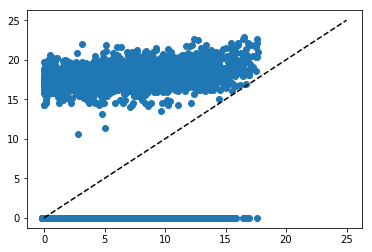

In [60]:
plt.scatter(censemble.predict(x), y)
plt.plot((0,25), (0,25), linestyle='--', color='k')

In [ ]:
with open('../models/cb_overfit_stage2.pkl', 'wb') as f:
    pickle.dump(censemble, f)

We see similar results to the random forest model found before.  Again, the strategy still seems to be guessing conservatively, especially since we do not allow it to train into overfitting by much.  With the better score, this model seems to be picking up on something not trivial, and we see a slightly more convincing upward trajectory in guessing low and high user transaction sums.  While this model could not predict the amount a user spends reliably, it can at least assign a relative value to users.